# plan

- import wide form score table and the score index key
- use the mask array to convert the score lists to single value scores
- generate bootstrapping replicates - 1000x
  - resample the table with replacement 1000x and store results in a list of dataframes
  - resampled replicates will have the same number or TPs and FPs for each SLiM as the original data
  - convert each replicate into a long form table
  - calculate auPRC scores for each replicate - both combined and for each SLiM
- calculate confidence intervals to use for error bars
- calculate significance of differences between auPRC scores that I refer to use in the manuscript

In [2]:
import slim_conservation_scoring.seqtools.general_utils as tools
import pandas as pd
import numpy as np
import slim_conservation_scoring.pipeline.group_conservation_objects as group_tools
import json
import os
import re
import sys
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align
import matplotlib.pyplot as plt
plt.style.use('custom_standard')
# plt.style.use('custom_small')
import seaborn as sns
# pd.options.plotting.backend = "plotly"
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
zscores = pd.read_csv('./z_scores_wideform.csv')
score_key = pd.read_csv('./z_scores_score_key.csv')
score_indexes=[i for i in zscores.columns if i in score_key['score_index'].unique()]

from ast import literal_eval
for col in score_indexes:
    zscores[col] = zscores[col].apply(literal_eval)

zscores['mask_array'] = zscores['mask_array'].str.replace(' ', ',')
zscores['mask_array'] = zscores['mask_array'].apply(literal_eval)

def extract_important_scores(s, colname):
    scores = np.array(s[colname])
    maskarr = np.array(s["mask_array"])
    mask = maskarr.nonzero()
    return scores[mask]

zscores2=zscores.copy()
for i in score_indexes:
    zscores2[i] = zscores2.apply(lambda x: extract_important_scores(x, i), axis=1)
    zscores2[i] = zscores2[i].apply(np.mean)
zscores2 = zscores2[zscores2['ELM_motif_class'] != 'TRAF6']

In [4]:
def get_stratified_sample(dfin, class_col):
    df = dfin.copy()
    tp = df[df[class_col]==True].copy().sample(frac=1, replace=True)
    fp = df[df[class_col]==False].copy().sample(frac=1, replace=True)
    return pd.concat([tp, fp], ignore_index=True)


def make_bootstrap_sample(dfin):
    df = dfin.copy()
    motifs = df['ELM_motif_class'].unique()
    t = [get_stratified_sample(df[df['ELM_motif_class']==i].copy(), 'verified interaction') for i in motifs]
    return pd.concat(t, ignore_index=True)

In [5]:
n_bootstraps = 1000
counter = 0
bootstrap_samples = []
for i in range(n_bootstraps):
    bootstrap_samples.append(make_bootstrap_sample(zscores2))
    counter += 1
    if counter % 100 == 0:
        print(f"Completed {counter} bootstraps")

Completed 100 bootstraps
Completed 200 bootstraps
Completed 300 bootstraps
Completed 400 bootstraps
Completed 500 bootstraps
Completed 600 bootstraps
Completed 700 bootstraps
Completed 800 bootstraps
Completed 900 bootstraps
Completed 1000 bootstraps


# general auPRC - combining all of the SLiMs and treating as a single dataset

In [6]:
from collections import defaultdict
bootstrap_auprc_dict = defaultdict(list)
for i in score_indexes:
    for sample in bootstrap_samples:
        prc_results = tools.df_2_precision_recall_curve(sample, 'verified interaction', score_col=i)
        bootstrap_auprc_dict[i].append(prc_results[3])

In [7]:
confidence_intervals = defaultdict(list)
for k, v in bootstrap_auprc_dict.items():
    confidence_intervals[k] = np.percentile(v, [2.5, 97.5])

(0.0, 1.0)

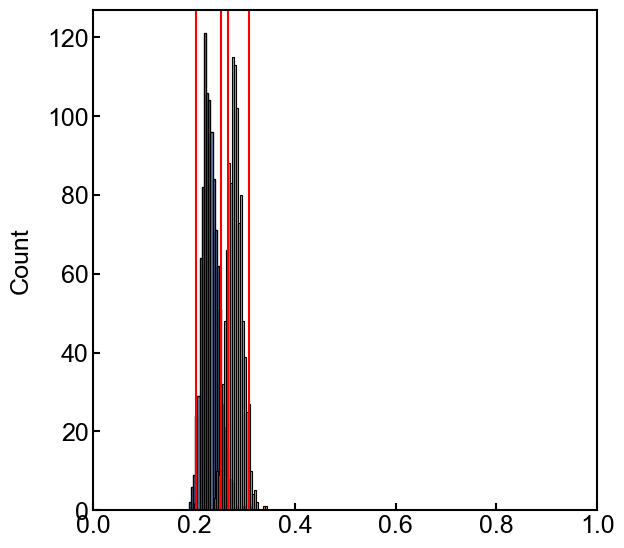

In [8]:
sns.histplot(bootstrap_auprc_dict['0.0'])
plt.axvline(confidence_intervals['0.0'][0], color='red')
plt.axvline(confidence_intervals['0.0'][1], color='red')
sns.histplot(bootstrap_auprc_dict['kibby_hit_zscores'])
plt.axvline(confidence_intervals['kibby_hit_zscores'][0], color='red')
plt.axvline(confidence_intervals['kibby_hit_zscores'][1], color='red')
plt.xlim(0, 1)

put bootstrapping results into a dataframe

In [9]:
general_auprc_df = score_key[score_key['score_index'].isin(score_indexes)].copy()
general_auprc_df['CI'] = general_auprc_df['score_index'].map(confidence_intervals)
# split CI into two columns
general_auprc_df[['CI_lower', 'CI_upper']] = pd.DataFrame(general_auprc_df['CI'].tolist(), index=general_auprc_df.index)
general_auprc_df=general_auprc_df.drop(columns=['CI'])

add real auPRC score to the dataframe

In [10]:
auprc_dict = {}
for i in score_indexes:
    prc_results = tools.df_2_precision_recall_curve(zscores2, 'verified interaction', score_col=i)
    auprc_dict[i] = prc_results[3]
general_auprc_df['auPRC'] = general_auprc_df['score_index'].map(auprc_dict)

[]

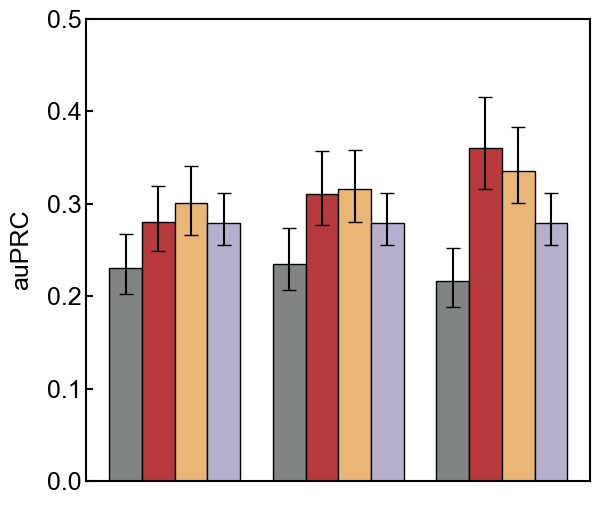

In [15]:
temp = general_auprc_df[
    (general_auprc_df['rflank']!='5.0')
].copy()
temp=temp[temp['score_key']!='pairk_aln_dr_bert_embedding_lf0_rf0']
fig, ax = plt.subplots(figsize=(6.5, 6))
sns.barplot(
    data=temp, 
    x='level', 
    y='auPRC', 
    hue='score_key', 
    hue_order=[
        'aln_property_entropy',
        'pairk_aln_lf0_rf0_edssmat50',
        'pairk_aln_embedding_lf0_rf0',
        'kibby',
    ],
    palette={'aln_property_entropy': '#7f8585', 'kibby': '#b2abd2', 'pairk_aln_lf0_rf0_edssmat50': '#cc2529', 'pairk_aln_embedding_lf0_rf0':'#fdb863'},
    ax=ax,
    legend=False,
)
# add confidence intervals to the plot as error bars
for i, bar in enumerate(ax.patches):
    ci = temp.iloc[i,:]
    ax.errorbar(
        x=bar.get_x() + bar.get_width() / 2,
        y=bar.get_height(),
        # yerr=[[bar.get_height()-ci['CI_lower']], [ci['CI_upper']-bar.get_height()]],
        yerr=[[bar.get_height()-ci['CI_lower']], [ci['CI_upper']-bar.get_height()]],
        color='black',
        capsize=5,
    )
ax.set_ylim(0, 0.5)
ax.set_xlabel('')
# remove the xticks
ax.set_xticks([])
# bar_positions = [patch.get_x() + patch.get_width() / 2 for patch in ax.patches]

It seems like the `ax.patches` are in the order of the original dataframe, so I can use the index to get the correct error bar values. See the test below.

In [16]:
for i, bar in enumerate(ax.patches):
    tempi = temp.iloc[i,:]
    print(i, bar.get_height(), tempi['auPRC'], tempi['CI_lower'], tempi['CI_upper'])
    assert bar.get_height() == tempi['auPRC']

0 0.23068751010166982 0.23068751010166982 0.20266060984065673 0.26783283117169937
1 0.2348842097437964 0.2348842097437964 0.20713796288447703 0.27330404120574797
2 0.2160588665114797 0.2160588665114797 0.18819204755456947 0.2524223235132487
3 0.2800715379485664 0.2800715379485664 0.2489108510114208 0.31939187421466714
4 0.3106387766348376 0.3106387766348376 0.2765776019738488 0.35677466695451815
5 0.360359673062666 0.360359673062666 0.31632068344360903 0.4157265812104045
6 0.3008410238446014 0.3008410238446014 0.2665808838450126 0.3414151686727886
7 0.3157251088019422 0.3157251088019422 0.28072807114066145 0.35838101647840825
8 0.33601914277760286 0.33601914277760286 0.30051415383957775 0.3832355287740289
9 0.27871801106344835 0.27871801106344835 0.25581516150048583 0.3114397666214602
10 0.27871801106344835 0.27871801106344835 0.25581516150048583 0.3114397666214602
11 0.27871801106344835 0.27871801106344835 0.25581516150048583 0.3114397666214602


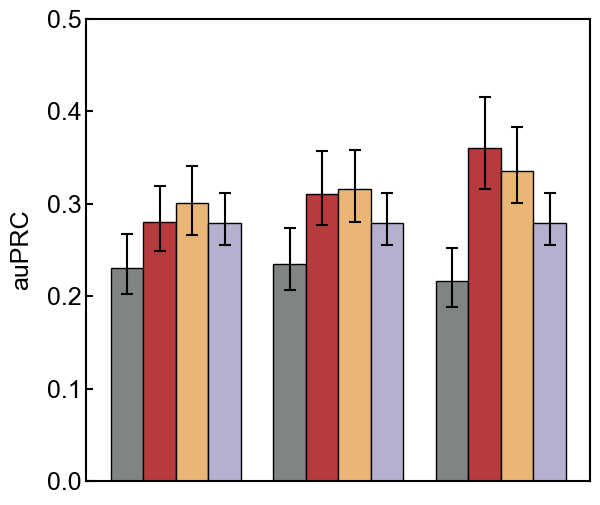

In [17]:
temp = general_auprc_df.copy()
temp = temp[temp["rflank"] != "5.0"]
temp = temp[temp["score_key"] != "pairk_aln_dr_bert_embedding_lf0_rf0"]
fig, ax = plt.subplots(figsize=(6.5, 6))
colormap = {
    "aln_property_entropy": "#7f8585",
    "kibby": "#b2abd2",
    "pairk_aln_lf0_rf0_edssmat50": "#cc2529",
    "pairk_aln_embedding_lf0_rf0": "#fdb863",
}
# change the saturation of the hex colors
colormap = {k: sns.desaturate(v, 0.75) for k, v in colormap.items()}
labels = general_auprc_df["level"].unique()
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0
for i in temp["score_key"].unique():
    temp2 = temp[temp["score_key"] == i].copy()
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        temp2["auPRC"],
        width,
        label=i,
        color=colormap[i],
        yerr=[
            temp2["auPRC"] - temp2["CI_lower"],
            temp2["CI_upper"] - temp2["auPRC"],
        ],
        error_kw={"elinewidth": 1.5, "capthick": 1.5, "capsize": 4},
    )
    multiplier += 1

ax.set_xticks(x + width * 1.5, labels)
ax.set_xlim(-0.25, len(labels) - 0.15)
ax.set_ylim(0, 0.5)
ax.set_xlabel('')
# remove the xticks
ax.set_xticks([])
# plt.xticks(rotation=60, horizontalalignment="right")
ax.set_ylabel("auPRC")
plt.savefig('./figure4/auPRC_barplot_general-rbm_f.png', bbox_inches='tight', dpi=400)

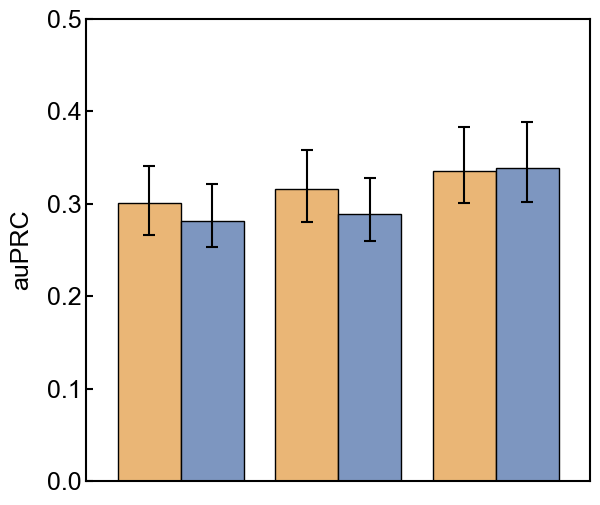

In [18]:
temp = general_auprc_df.copy()
temp = temp[temp["rflank"] != "5.0"]
temp = temp[temp["score_key"].isin(["pairk_aln_dr_bert_embedding_lf0_rf0", "pairk_aln_embedding_lf0_rf0"])]
fig, ax = plt.subplots(figsize=(6.5, 6))
colormap = {
    "aln_property_entropy": "#7f8585",
    "kibby": "#b2abd2",
    "pairk_aln_lf0_rf0_edssmat50": "#cc2529",
    "pairk_aln_embedding_lf0_rf0": "#fdb863",
    'pairk_aln_dr_bert_embedding_lf0_rf0': '#7293cb',
}
# change the saturation of the hex colors
colormap = {k: sns.desaturate(v, 0.75) for k, v in colormap.items()}
labels = general_auprc_df["level"].unique()
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars
multiplier = 1
for i in temp["score_key"].unique():
    temp2 = temp[temp["score_key"] == i].copy()
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        temp2["auPRC"],
        width,
        label=i,
        color=colormap[i],
        yerr=[
            temp2["auPRC"] - temp2["CI_lower"],
            temp2["CI_upper"] - temp2["auPRC"],
        ],
        error_kw={"elinewidth": 1.5, "capthick": 1.5, "capsize": 4},
    )
    multiplier += 1

ax.set_xticks(x + width * 1.5, labels)
ax.set_xlim(-0, len(labels) + 0.2)
ax.set_ylim(0, 0.5)
ax.set_xlabel('')
# remove the xticks
ax.set_xticks([])
# plt.xticks(rotation=60, horizontalalignment="right")
ax.set_ylabel("auPRC")
plt.savefig('./supplement/dr_bert/auPRC_barplot_general.png', bbox_inches='tight', dpi=400)

# per SLiM auPRC scores and bootstraps

real auPRC scores

In [11]:
from collections import defaultdict
auprc_slim_dict = defaultdict(list)
for s in zscores2['ELM_motif_class'].unique():
    temp = zscores2[zscores2['ELM_motif_class']==s].copy()
    for i in score_indexes:
        prc_results = tools.df_2_precision_recall_curve(temp, 'verified interaction', score_col=i)
        auprc_slim_dict['score_index'].append(i)
        auprc_slim_dict['ELM_motif_class'].append(s)
        auprc_slim_dict['auPRC'].append(prc_results[3])
auprc_slim_df = pd.DataFrame(auprc_slim_dict)
auprc_slim_df = pd.merge(auprc_slim_df, score_key, on='score_index', how='left')

In [12]:
auprc_slim_df[auprc_slim_df.duplicated(subset=['score_index', 'ELM_motif_class'])]

,score_index,ELM_motif_class,auPRC,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing
16,kibby_hit_zscores,LIG_AP2alpha_2,0.281147,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
17,kibby_hit_zscores,LIG_AP2alpha_2,0.281147,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby
34,kibby_hit_zscores,LIG_EH_1,0.311542,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
35,kibby_hit_zscores,LIG_EH_1,0.311542,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby
52,kibby_hit_zscores,LIG_SH2_GRB2like,0.279734,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
53,kibby_hit_zscores,LIG_SH2_GRB2like,0.279734,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby
70,kibby_hit_zscores,LIG_SH3_CIN85_PxpxPR_1,0.378311,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
71,kibby_hit_zscores,LIG_SH3_CIN85_PxpxPR_1,0.378311,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby
88,kibby_hit_zscores,DOC_WW_Pin1_4,0.159992,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby
89,kibby_hit_zscores,DOC_WW_Pin1_4,0.159992,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby


Bootstrap auprc and confidence intervals

In [13]:
bootstrap_slim_dict = defaultdict(list)
for slim in zscores2['ELM_motif_class'].unique():
    auprc_dict_s = defaultdict(list)
    for sample in bootstrap_samples:
        sample_s = sample[sample['ELM_motif_class']==slim].copy()
        for i in score_indexes:
            prc_results = tools.df_2_precision_recall_curve(sample_s, 'verified interaction', score_col=i)
            auprc_dict_s[i].append(prc_results[3])
    for score_index, auprc_list in auprc_dict_s.items():
        bootstrap_slim_dict['score_index'].append(score_index)
        bootstrap_slim_dict['ELM_motif_class'].append(slim)
        bootstrap_slim_dict['CI'].append(np.percentile(auprc_list, [2.5, 97.5]))

In [14]:
bootstrap_slim_df=pd.DataFrame(bootstrap_slim_dict)
auprc_slim_df=pd.merge(auprc_slim_df, bootstrap_slim_df, on=['score_index', 'ELM_motif_class'], how='left')
auprc_slim_df[['CI_lower', 'CI_upper']] = pd.DataFrame(auprc_slim_df['CI'].tolist(), index=auprc_slim_df.index)
auprc_slim_df=auprc_slim_df.drop(columns=['CI'])

In [15]:
auprc_slim_df

,score_index,ELM_motif_class,auPRC,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing,CI_lower,CI_upper
0,0.0,LIG_AP2alpha_2,0.257687,MSA - MAFFT,Tetrapoda,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2464,0.196456,0.360788
1,2.0,LIG_AP2alpha_2,0.238534,MSA - MAFFT,Vertebrata,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2606,0.190488,0.307391
2,4.0,LIG_AP2alpha_2,0.230370,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2404,0.177852,0.318782
3,8.0,LIG_AP2alpha_2,0.334931,Pairwise,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663,0.283483,0.409387
4,9.0,LIG_AP2alpha_2,0.280585,Pairwise,Tetrapoda,pairk_aln_lf5_rf5_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,5.0,5.0,property_entropy,2565,0.230329,0.344769
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,38.0,Ena/VASP ([FL]PPPP),0.319287,Pairwise embedding,Metazoa,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844,0.231032,0.462196
122,39.0,Ena/VASP ([FL]PPPP),0.297819,Pairwise embedding,Metazoa,pairk_aln_dr_bert_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844,0.219419,0.451679
123,kibby_hit_zscores,Ena/VASP ([FL]PPPP),0.363260,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby,0.243760,0.503180
124,kibby_hit_zscores,Ena/VASP ([FL]PPPP),0.363260,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby,0.243760,0.503180


Text(0, 0.5, 'auPRC')

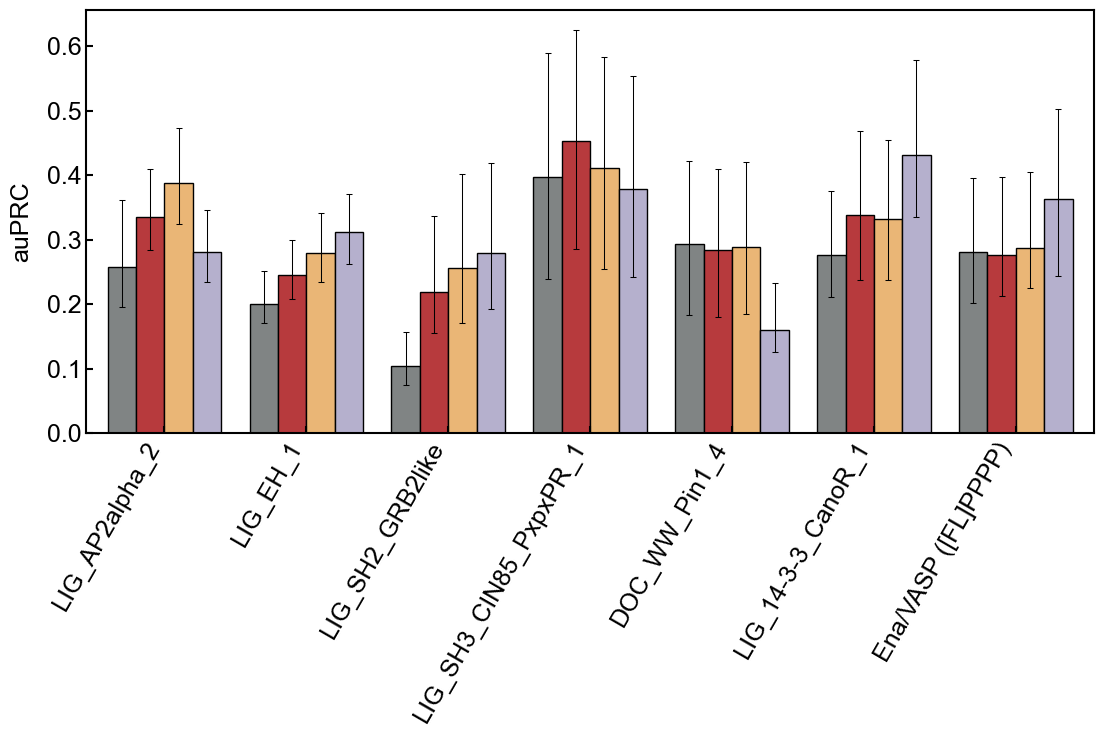

In [17]:
temp = auprc_slim_df.copy()
temp = temp[
    (temp["level"] == "Tetrapoda")
].copy()
temp = temp[temp["rflank"] != "5.0"]
temp = temp[temp["score_key"] != "pairk_aln_dr_bert_embedding_lf0_rf0"]
# fig, ax = plt.subplots(figsize=(12, 8.5))
fig, ax = plt.subplots(figsize=(13, 5.5))
colormap = {
    "aln_property_entropy": "#7f8585",
    "kibby": "#b2abd2",
    "pairk_aln_lf0_rf0_edssmat50": "#cc2529",
    "pairk_aln_embedding_lf0_rf0": "#fdb863",
}
# change the saturation of the hex colors
colormap = {k: sns.desaturate(v, 0.75) for k, v in colormap.items()}
labels = temp["ELM_motif_class"].unique()
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0
for i in temp["score_key"].unique():
    temp2 = temp[temp["score_key"] == i].copy()
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        temp2["auPRC"],
        width,
        label=i,
        color=colormap[i],
        yerr=[
            temp2["auPRC"] - temp2["CI_lower"],
            temp2["CI_upper"] - temp2["auPRC"],
        ],
        error_kw={"elinewidth": 0.75, "capthick": 0.75, "capsize": 2},
    )
    multiplier += 1

ax.set_xticks(x + width * 1.5, labels)
ax.set_xlim(-0.25, len(labels) - 0.15)
plt.xticks(rotation=60, horizontalalignment="right")
ax.set_ylabel("auPRC")
# plt.savefig('./figure3/auPRC_barplot_classes_metazoa-rbm_f.png', bbox_inches='tight', dpi=400)

Text(0, 0.5, 'auPRC')

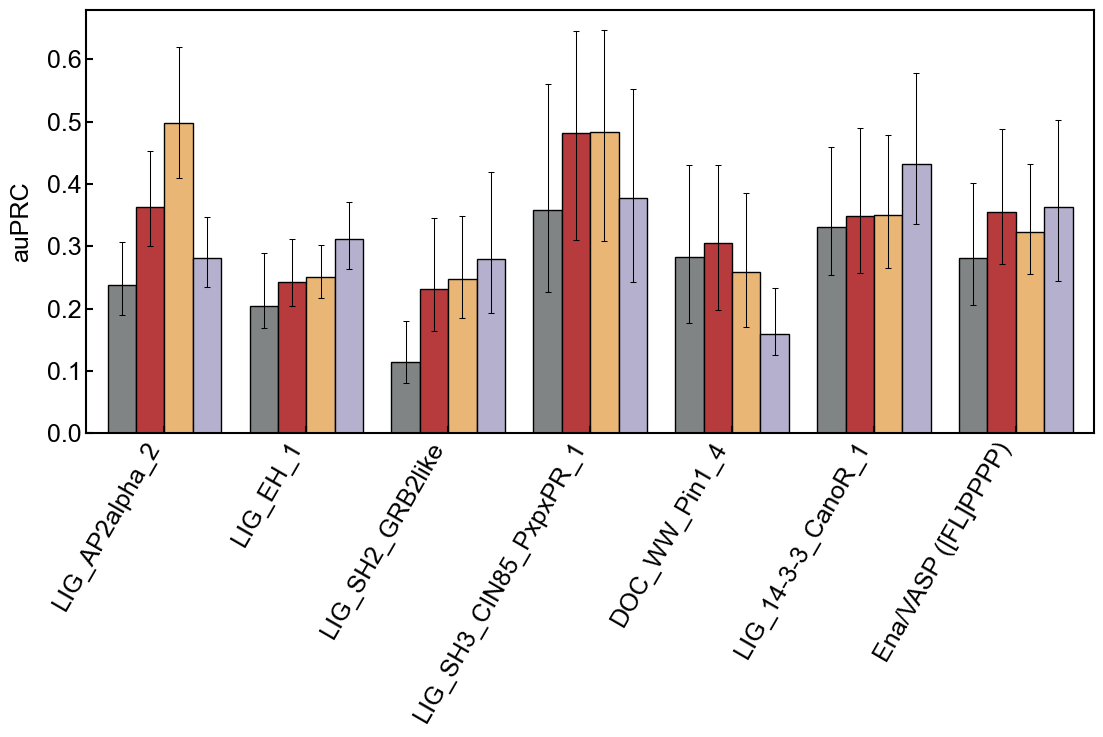

In [ ]:
temp = auprc_slim_df.copy()
temp = temp[
    (temp["level"] == "Vertebrata")
].copy()
temp = temp[temp["rflank"] != "5.0"]
temp = temp[temp["score_key"] != "pairk_aln_dr_bert_embedding_lf0_rf0"]
# fig, ax = plt.subplots(figsize=(12, 8.5))
fig, ax = plt.subplots(figsize=(13, 5.5))
colormap = {
    "aln_property_entropy": "#7f8585",
    "kibby": "#b2abd2",
    "pairk_aln_lf0_rf0_edssmat50": "#cc2529",
    "pairk_aln_embedding_lf0_rf0": "#fdb863",
}
# change the saturation of the hex colors
colormap = {k: sns.desaturate(v, 0.75) for k, v in colormap.items()}
labels = temp["ELM_motif_class"].unique()
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0
for i in temp["score_key"].unique():
    temp2 = temp[temp["score_key"] == i].copy()
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        temp2["auPRC"],
        width,
        label=i,
        color=colormap[i],
        yerr=[
            temp2["auPRC"] - temp2["CI_lower"],
            temp2["CI_upper"] - temp2["auPRC"],
        ],
        error_kw={"elinewidth": 0.75, "capthick": 0.75, "capsize": 2},
    )
    multiplier += 1

ax.set_xticks(x + width * 1.5, labels)
ax.set_xlim(-0.25, len(labels) - 0.15)
plt.xticks(rotation=60, horizontalalignment="right")
ax.set_ylabel("auPRC")
# plt.savefig('./figure3/auPRC_barplot_classes_metazoa-rbm_f.png', bbox_inches='tight', dpi=400)

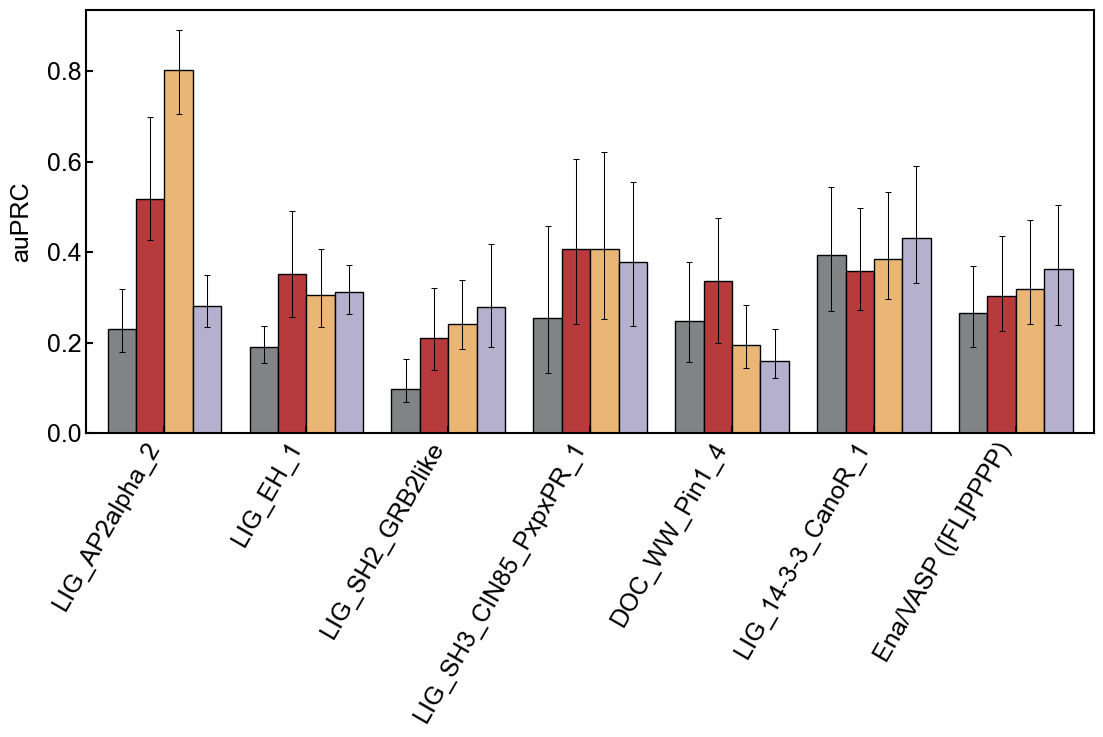

In [ ]:
temp = auprc_slim_df.copy()
temp = temp[
    (temp["level"] == "Metazoa")
].copy()
temp = temp[temp["rflank"] != "5.0"]
temp = temp[temp["score_key"] != "pairk_aln_dr_bert_embedding_lf0_rf0"]
# fig, ax = plt.subplots(figsize=(12, 8.5))
fig, ax = plt.subplots(figsize=(13, 5.5))
colormap = {
    "aln_property_entropy": "#7f8585",
    "kibby": "#b2abd2",
    "pairk_aln_lf0_rf0_edssmat50": "#cc2529",
    "pairk_aln_embedding_lf0_rf0": "#fdb863",
}
# change the saturation of the hex colors
colormap = {k: sns.desaturate(v, 0.75) for k, v in colormap.items()}
labels = temp["ELM_motif_class"].unique()
x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars
multiplier = 0
for i in temp["score_key"].unique():
    temp2 = temp[temp["score_key"] == i].copy()
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        temp2["auPRC"],
        width,
        label=i,
        color=colormap[i],
        yerr=[
            temp2["auPRC"] - temp2["CI_lower"],
            temp2["CI_upper"] - temp2["auPRC"],
        ],
        error_kw={"elinewidth": 0.75, "capthick": 0.75, "capsize": 2},
    )
    multiplier += 1

ax.set_xticks(x + width * 1.5, labels)
ax.set_xlim(-0.25, len(labels) - 0.15)
plt.xticks(rotation=60, horizontalalignment="right")
ax.set_ylabel("auPRC")
plt.savefig('./figure3/auPRC_barplot_classes_metazoa-rbm_f.png', bbox_inches='tight', dpi=400)

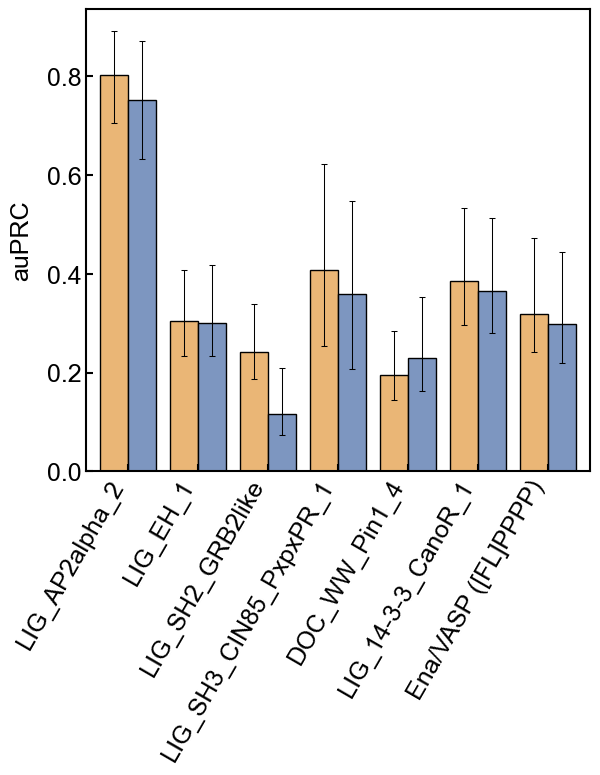

In [25]:
temp = auprc_slim_df.copy()
temp = temp[
    (temp["level"] == "Metazoa")
].copy()
temp = temp[temp["rflank"] != "5.0"]
temp = temp[temp["score_key"].isin(["pairk_aln_dr_bert_embedding_lf0_rf0", "pairk_aln_embedding_lf0_rf0"])]
fig, ax = plt.subplots(figsize=(6.5, 6))
# fig, ax = plt.subplots(figsize=(13, 5.5))
colormap = {
    "aln_property_entropy": "#7f8585",
    "kibby": "#b2abd2",
    "pairk_aln_lf0_rf0_edssmat50": "#cc2529",
    "pairk_aln_embedding_lf0_rf0": "#fdb863",
    'pairk_aln_dr_bert_embedding_lf0_rf0': '#7293cb',
}
# change the saturation of the hex colors
colormap = {k: sns.desaturate(v, 0.75) for k, v in colormap.items()}
labels = temp["ELM_motif_class"].unique()
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars
multiplier = 1
for i in temp["score_key"].unique():
    temp2 = temp[temp["score_key"] == i].copy()
    offset = width * multiplier
    rects = ax.bar(
        x + offset,
        temp2["auPRC"],
        width,
        label=i,
        color=colormap[i],
        yerr=[
            temp2["auPRC"] - temp2["CI_lower"],
            temp2["CI_upper"] - temp2["auPRC"],
        ],
        error_kw={"elinewidth": 0.75, "capthick": 0.75, "capsize": 2},
    )
    multiplier += 1

ax.set_xticks(x + width * 1.5, labels)
ax.set_xlim(-0, len(labels) + 0.2)
plt.xticks(rotation=60, horizontalalignment="right")
ax.set_ylabel("auPRC")
plt.savefig('./supplement/dr_bert/auPRC_barplot_classes_metazoa.png', bbox_inches='tight', dpi=400)

In [19]:
temp = auprc_slim_df.copy()
temp = temp[temp["rflank"] != "5.0"]
temp = temp[temp["score_key"] != "pairk_aln_dr_bert_embedding_lf0_rf0"]

In [20]:
aln_df=temp[temp['aln_type']=='MSA - MAFFT'][["ELM_motif_class", "auPRC", "level"]].copy()
auprc_df_norm=pd.merge(temp, aln_df, on=['ELM_motif_class', 'level'], how='left', suffixes=('', '_aln'), validate='m:1')

auprc_df_norm["auPRC_diff"] = auprc_df_norm["auPRC"] - auprc_df_norm["auPRC_aln"]
auprc_df_norm["auPRC_increase"] = auprc_df_norm["auPRC"] / auprc_df_norm["auPRC_aln"]
auprc_df_norm["auPRC_log_increase"] = np.log10(
    auprc_df_norm["auPRC"] / auprc_df_norm["auPRC_aln"]
)
auprc_df_norm.tail(10)

,score_index,ELM_motif_class,auPRC,aln_type,level,score_key,table_file,lflank,rflank,columnwise_score_function_name,num_passing,CI_lower,CI_upper,auPRC_aln,auPRC_diff,auPRC_increase,auPRC_log_increase
74,4.0,Ena/VASP ([FL]PPPP),0.265646,MSA - MAFFT,Metazoa,aln_property_entropy,/home/jch/Documents/08-benchmark/benchmark/ben...,MSA,MSA,property_entropy,2404,0.186242,0.376515,0.265646,0.000000,1.000000,0.000000
75,8.0,Ena/VASP ([FL]PPPP),0.276587,Pairwise,Tetrapoda,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663,0.212705,0.397459,0.280820,-0.004233,0.984925,-0.006597
76,19.0,Ena/VASP ([FL]PPPP),0.354625,Pairwise,Vertebrata,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2823,0.271472,0.487479,0.281243,0.073382,1.260919,0.100687
77,26.0,Ena/VASP ([FL]PPPP),0.303212,Pairwise,Metazoa,pairk_aln_lf0_rf0_edssmat50,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844,0.224210,0.431976,0.265646,0.037566,1.141413,0.057443
78,30.0,Ena/VASP ([FL]PPPP),0.287523,Pairwise embedding,Tetrapoda,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2663,0.225677,0.404931,0.280820,0.006703,1.023870,0.010245
79,34.0,Ena/VASP ([FL]PPPP),0.322193,Pairwise embedding,Vertebrata,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2823,0.254879,0.432340,0.281243,0.040949,1.145602,0.059034
80,38.0,Ena/VASP ([FL]PPPP),0.319287,Pairwise embedding,Metazoa,pairk_aln_embedding_lf0_rf0,/home/jch/Documents/08-benchmark/benchmark/ben...,0.0,0.0,property_entropy,2844,0.231032,0.462196,0.265646,0.053641,1.201926,0.079878
81,kibby_hit_zscores,Ena/VASP ([FL]PPPP),0.363260,kibby,Metazoa,kibby,kibby,kibby,kibby,kibby,kibby,0.243760,0.503180,0.265646,0.097614,1.367460,0.135915
82,kibby_hit_zscores,Ena/VASP ([FL]PPPP),0.363260,kibby,Tetrapoda,kibby,kibby,kibby,kibby,kibby,kibby,0.243760,0.503180,0.280820,0.082441,1.293571,0.111790
83,kibby_hit_zscores,Ena/VASP ([FL]PPPP),0.363260,kibby,Vertebrata,kibby,kibby,kibby,kibby,kibby,kibby,0.243760,0.503180,0.281243,0.082017,1.291624,0.111136


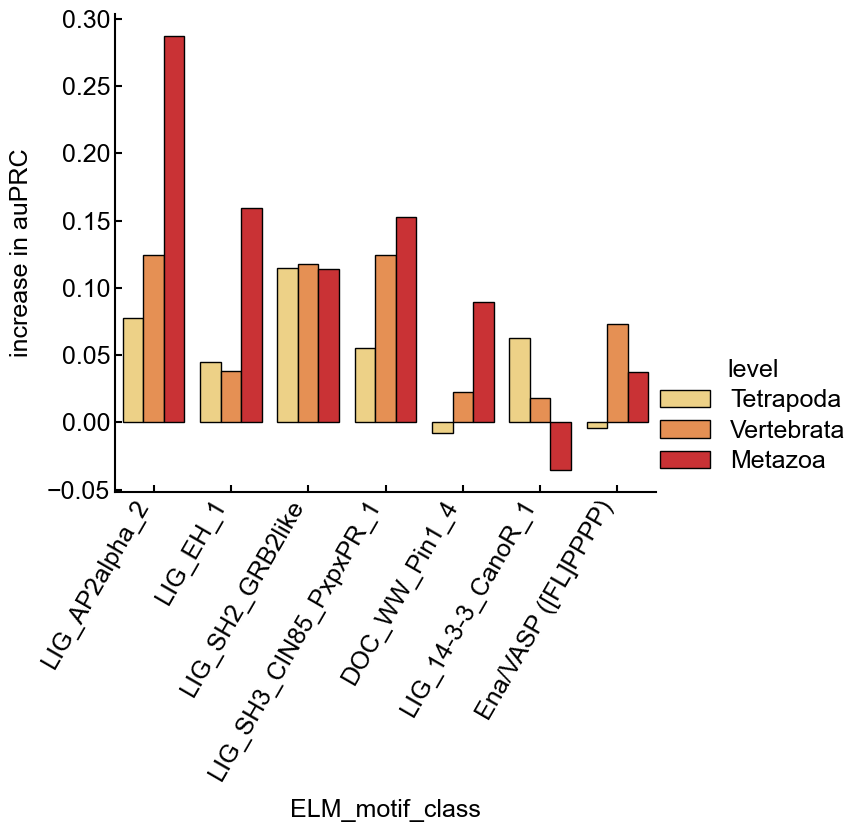

In [28]:
plot = sns.catplot(
    data=auprc_df_norm[auprc_df_norm['score_key']=='pairk_aln_lf0_rf0_edssmat50'],
    y="auPRC_diff",
    x='ELM_motif_class',
    hue='level',
    kind='bar',
    aspect=1.2,
    height=6,
    palette="YlOrRd",
    legend_out=True,
)
plot.set_ylabels('increase in auPRC')
plot.set_xticklabels(rotation=60, horizontalalignment="right")
plt.savefig('./figure4/increase_in_auPRC_per_class.png', bbox_inches='tight', dpi=400)

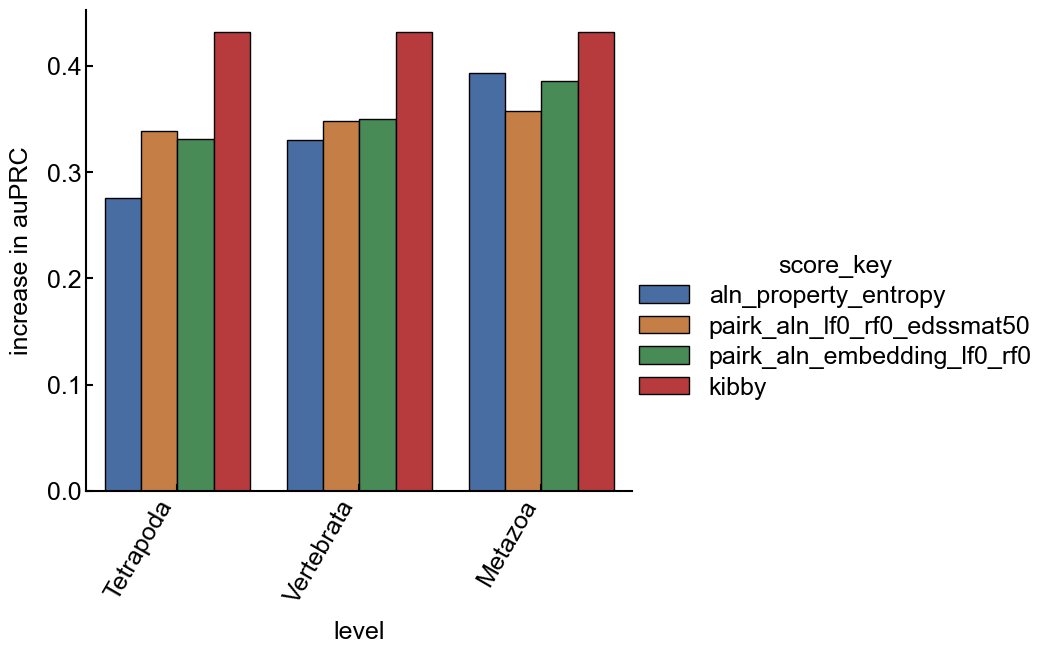

In [23]:
plot = sns.catplot(
    data=auprc_df_norm[auprc_df_norm['ELM_motif_class']=='LIG_14-3-3_CanoR_1'],
    y="auPRC",
    x='level',
    hue='score_key',
    kind='bar',
    aspect=1.2,
    height=6,
    # palette="YlOrRd",
    legend_out=True,
)
plot.set_ylabels('increase in auPRC')
plot.set_xticklabels(rotation=60, horizontalalignment="right")

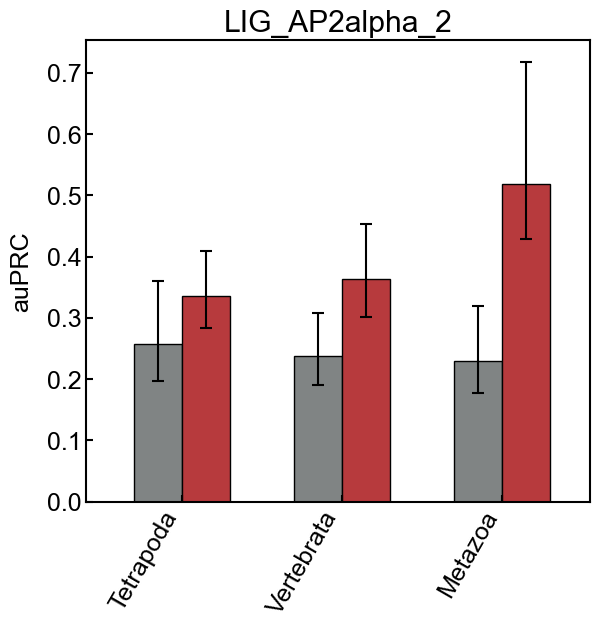

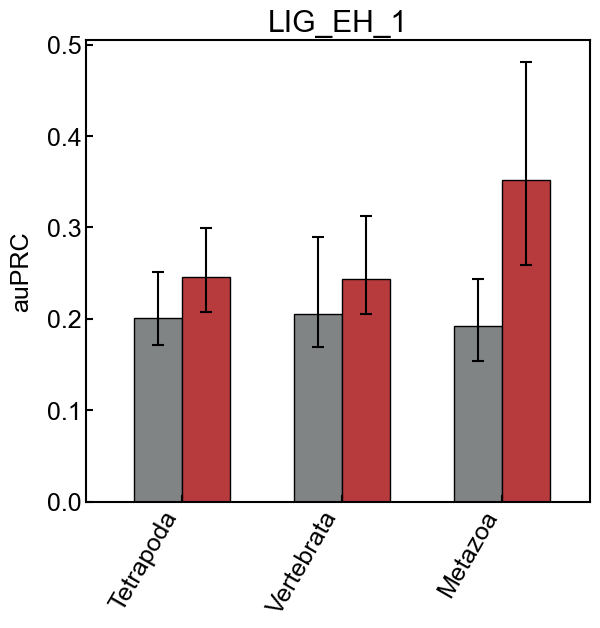

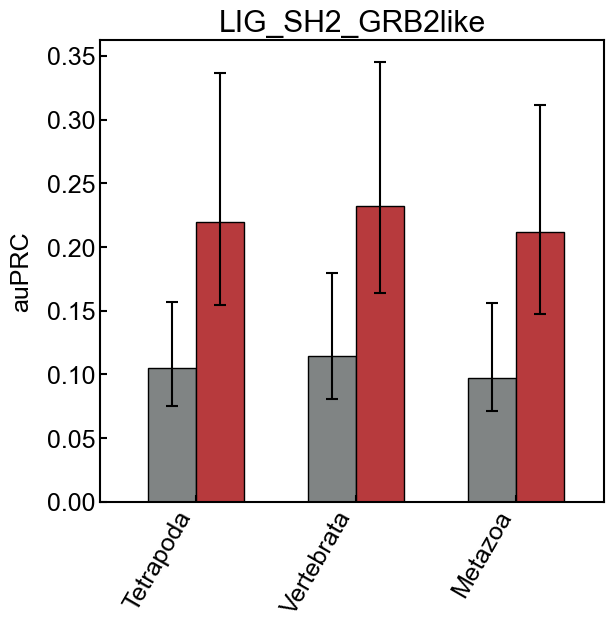

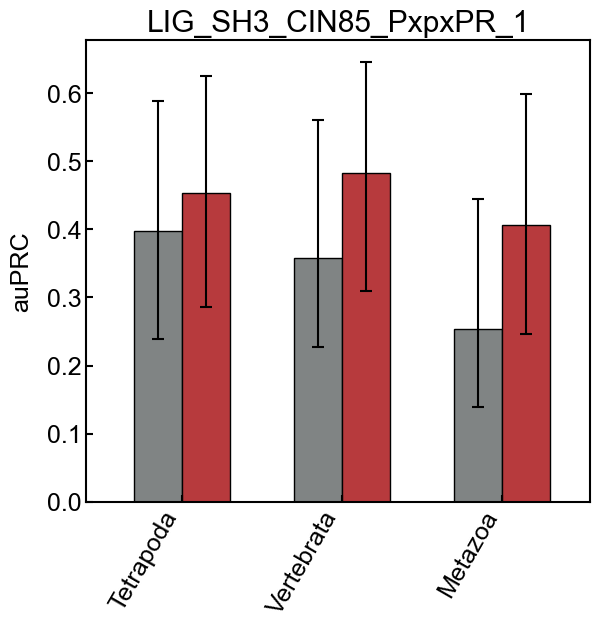

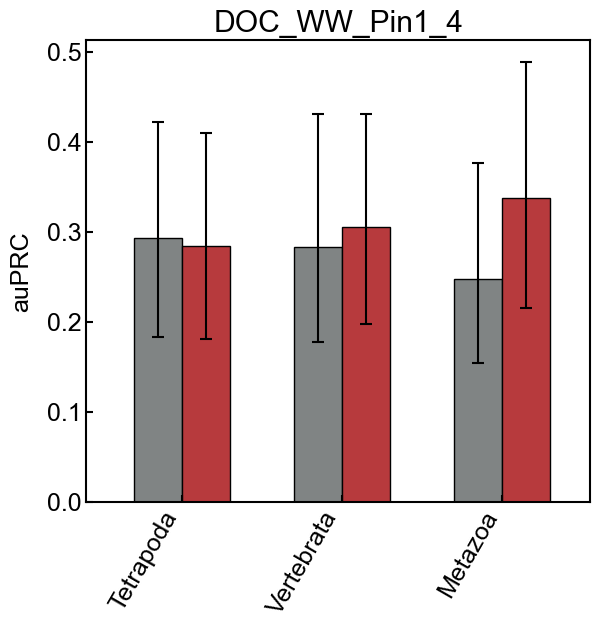

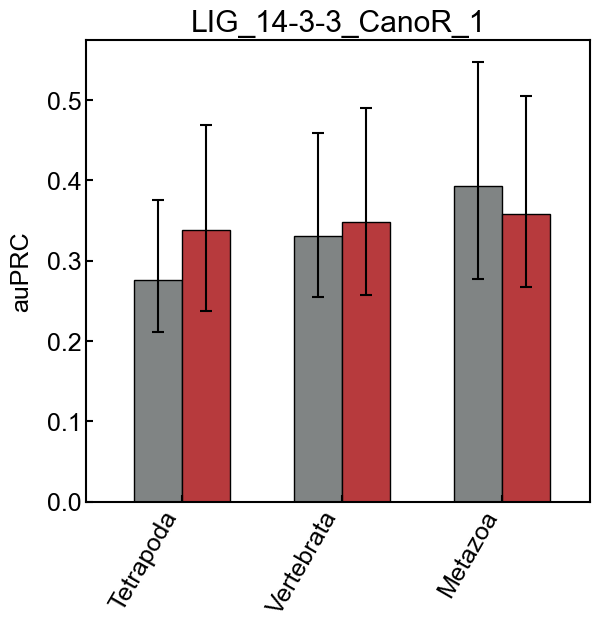

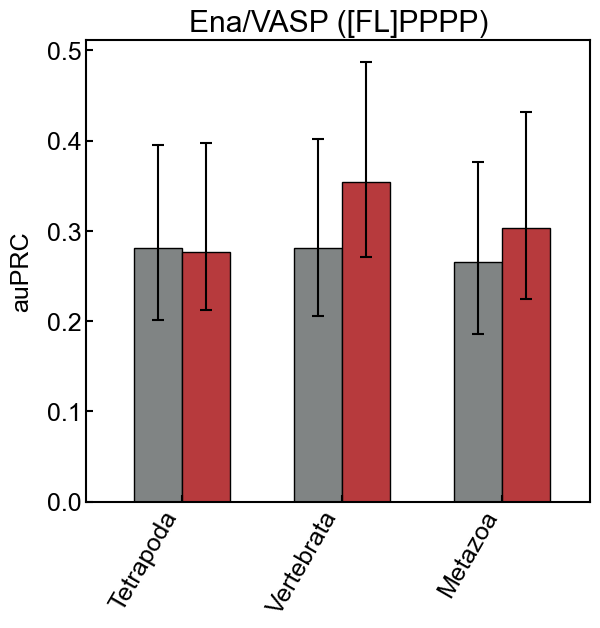

In [33]:
temp = auprc_df_norm.copy()
temp = temp[temp["rflank"] != "5.0"]
temp = temp[temp["score_key"].isin(['pairk_aln_lf0_rf0_edssmat50','aln_property_entropy'])]
colormap = {
    "aln_property_entropy": "#7f8585",
    "pairk_aln_lf0_rf0_edssmat50": "#cc2529",
}
# change the saturation of the hex colors
colormap = {k: sns.desaturate(v, 0.75) for k, v in colormap.items()}
labels = auprc_df_norm["level"].unique()
x = np.arange(len(labels))  # the label locations
for slm in temp["ELM_motif_class"].unique():
    width = 0.3  # the width of the bars
    multiplier = 1
    fig, ax = plt.subplots(figsize=(6.5, 6))
    temp2 = temp[temp["ELM_motif_class"] == slm].copy()
    for i in temp2["score_key"].unique():
        temp3 = temp2[temp2["score_key"] == i].copy()
        offset = width * multiplier
        rects = ax.bar(
            x + offset,
            temp3["auPRC"],
            width,
            label=i,
            color=colormap[i],
            yerr=[
                temp3["auPRC"] - temp3["CI_lower"],
                temp3["CI_upper"] - temp3["auPRC"],
            ],
            error_kw={"elinewidth": 1.5, "capthick": 1.5, "capsize": 4},
        )
        multiplier += 1
    ax.set_xticks(x + width * 1.5, labels)
    ax.set_xlim(-0.15, len(labels) - 0)
    ax.set_title(slm)
    # ax.set_ylim(0, 0.5)
    ax.set_xlabel('')
    # remove the xticks
    # ax.set_xticks([])
    plt.xticks(rotation=60, horizontalalignment="right")
    ax.set_ylabel("auPRC")

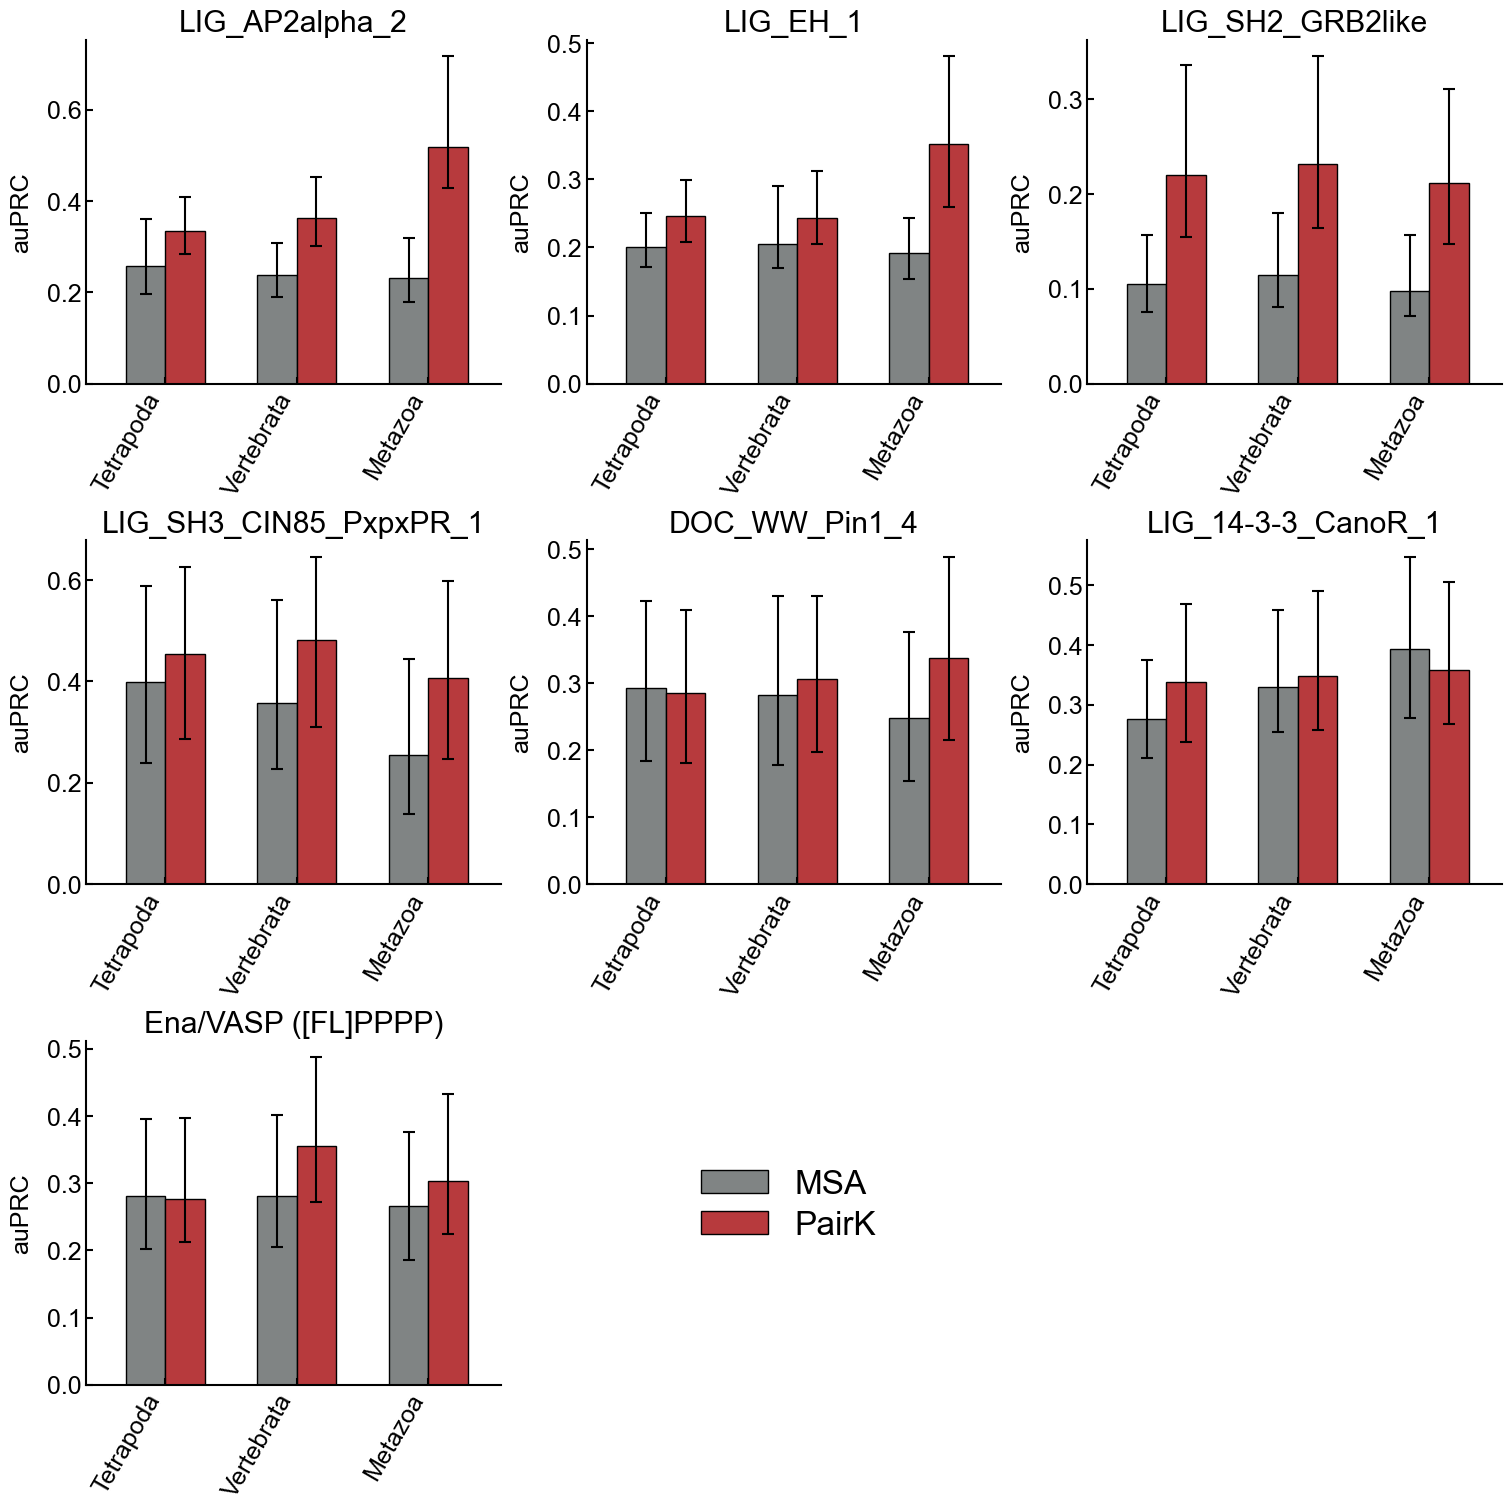

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Data and preprocessing
temp = auprc_df_norm.copy()
temp = temp[temp["rflank"] != "5.0"]
temp = temp[temp["score_key"].isin(['pairk_aln_lf0_rf0_edssmat50', 'aln_property_entropy'])]

# Colormap and saturation adjustment
colormap = {
    "aln_property_entropy": "#7f8585",
    "pairk_aln_lf0_rf0_edssmat50": "#cc2529",
}
colormap = {k: sns.desaturate(v, 0.75) for k, v in colormap.items()}

# Set up labels and x positions
labels = auprc_df_norm["level"].unique()
x = np.arange(len(labels))  # the label locations

# Create the figure and subplots
motif_classes = temp["ELM_motif_class"].unique()
n_motifs = len(motif_classes)
n_cols = 3  # Adjust this depending on how you want to layout the subplots
n_rows = int(np.ceil(n_motifs / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15), constrained_layout=True)

# Flatten axes in case there's more than 1 row
axes = axes.flatten()

# Plot each ELM motif class in its respective subplot
for idx, slm in enumerate(motif_classes):
    ax = axes[idx]
    temp2 = temp[temp["ELM_motif_class"] == slm].copy()
    width = 0.3  # width of bars
    multiplier = 1

    for i in temp2["score_key"].unique():
        temp3 = temp2[temp2["score_key"] == i].copy()
        offset = width * multiplier
        ax.bar(
            x + offset,
            temp3["auPRC"],
            width,
            label=i,
            color=colormap[i],
            yerr=[
                temp3["auPRC"] - temp3["CI_lower"],
                temp3["CI_upper"] - temp3["auPRC"],
            ],
            error_kw={"elinewidth": 1.5, "capthick": 1.5, "capsize": 4},
        )
        multiplier += 1

    # Set labels and titles for each subplot
    ax.set_xticks(x + width * 1.5, labels)
    ax.set_xlim(-0.15, len(labels) - 0)
    ax.set_title(slm)
    ax.set_ylabel("auPRC")
    ax.set_xticklabels(labels, rotation=60, ha="right")
    # remove the top and right spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# add a legend to the right of the last subplot
fig.legend(
    loc="center right",
    labels=['MSA','PairK'],
    # title="Score Key",
    bbox_to_anchor=(0.6, 0.2),
    # increase fontsize of legend
    fontsize=24,
    # remove the border of the legend
    frameon=False,
)

# Hide any extra subplots if they exist
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Add legend and display the plot
# plt.legend(['MSA','PairK'], loc='upper right')
output_folder = Path("./supplement/class_PairK_v_MSA_by_level/")
output_folder.mkdir(exist_ok=True)
plt.savefig(output_folder / "auPRC_per_level_per_class_barplot.png", bbox_inches="tight", dpi=400)